In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing

# Load Style Transfer Model

In [2]:
config_path = 'configs/daytime.yaml'
gen_weights_path = 'trained_models/generator/daytime.pt'
device = 'cpu:0'

style_transformer = StyleTransformer(
    config_path,
    gen_weights_path,
    inference_size=256, # output image size
    device=device
)

# Load Test Image

(2048, 1162)


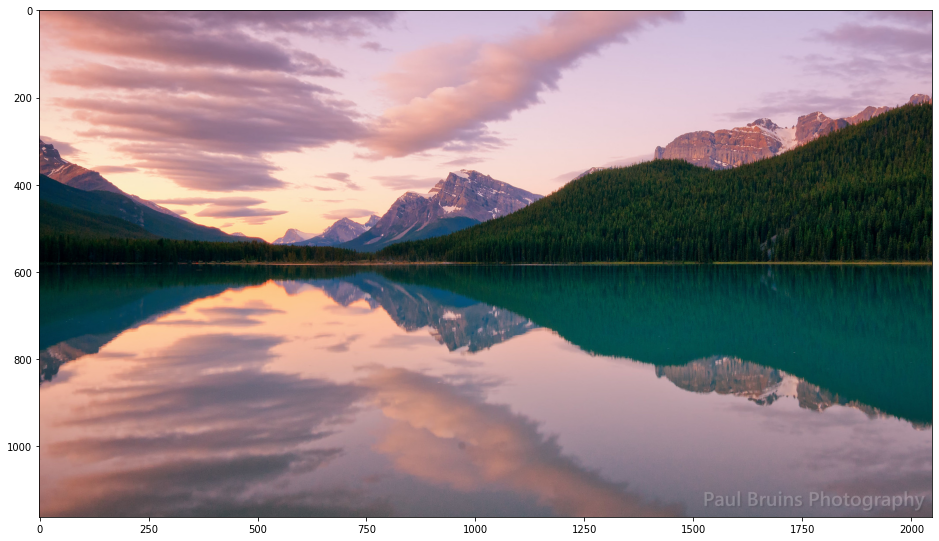

In [3]:
img_path = 'images/daytime/content/1.jpg'

img = Image.open(img_path)

print(img.size)
plt.figure(figsize=(16, 10))
plt.imshow(img)

# Load Style Parameters

In [4]:
from pprint import pprint

with open('styles.txt') as f:
    styles = f.read()

styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}

pprint(styles)

{'2minute': tensor([-0.3823,  0.5701, -0.9534]),
 '5minute': tensor([ 0.0393, -0.4581, -0.3173]),
 '5minutes2': tensor([-0.1544, -0.5920, -0.3295]),
 'another_night': tensor([ 0.0071, -1.3750, -0.3271]),
 'bluehour_bit_dark': tensor([-0.2956, -1.5699, -0.5350]),
 'bluehour_hard': tensor([ 0.4088, -1.6698,  0.2443]),
 'darknight': tensor([-0.4466, -1.3072, -0.3449]),
 'day': tensor([-0.2403,  0.4950,  0.2264]),
 'day2': tensor([-0.1528, -1.3118,  1.5012]),
 'hard_day': tensor([-0.0228, -0.3949,  0.8980]),
 'night': tensor([-0.4951, -1.0065, -1.0413]),
 'night2': tensor([-0.1531, -1.5918,  0.0850]),
 'nightmore': tensor([ 0.1075, -1.4487, -0.1843]),
 'onemorenight': tensor([ 0.2080, -1.5224, -0.0414]),
 'presunset': tensor([-0.2966,  0.5421, -0.6357]),
 'semihard_day': tensor([-0.1316,  0.0501,  0.5622]),
 'sunset_hard_harder': tensor([-0.5931,  1.0843, -1.2714]),
 'sunsetred': tensor([-0.1542,  0.1676, -1.7730])}


# Choose a Style

In [5]:
style_to_transfer = styles['bluehour_hard']

style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)

# Inference

(256, 448, 3)


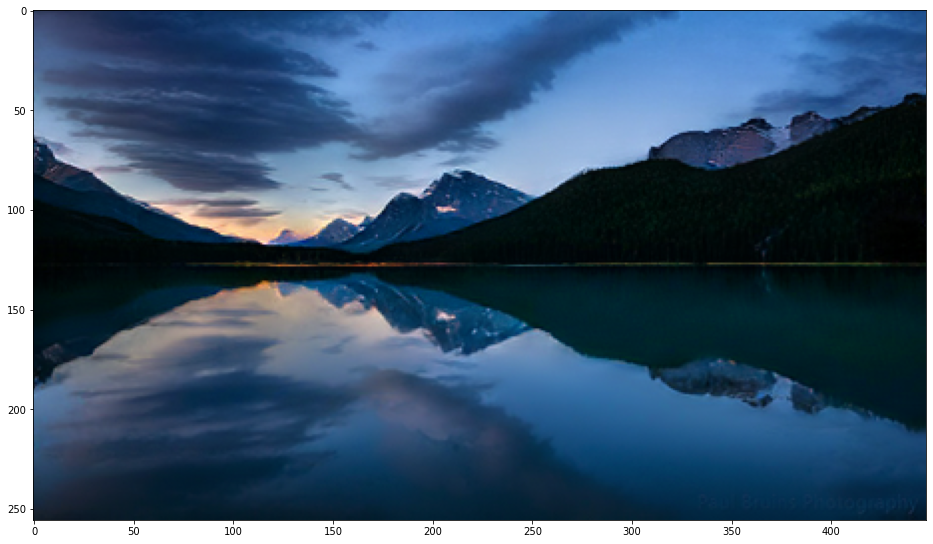

In [6]:
with torch.no_grad():
    content_decomposition = style_transformer.get_content(img)[0]

    decoder_input = {
        'content': content_decomposition['content'],
        'intermediate_outputs': content_decomposition['intermediate_outputs'],
        'style': style_to_transfer
    }

    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']
    
output_img = (transferred[0].cpu().clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.

print(output_img.shape)
plt.figure(figsize=(16, 10))
plt.imshow(output_img)

# Result

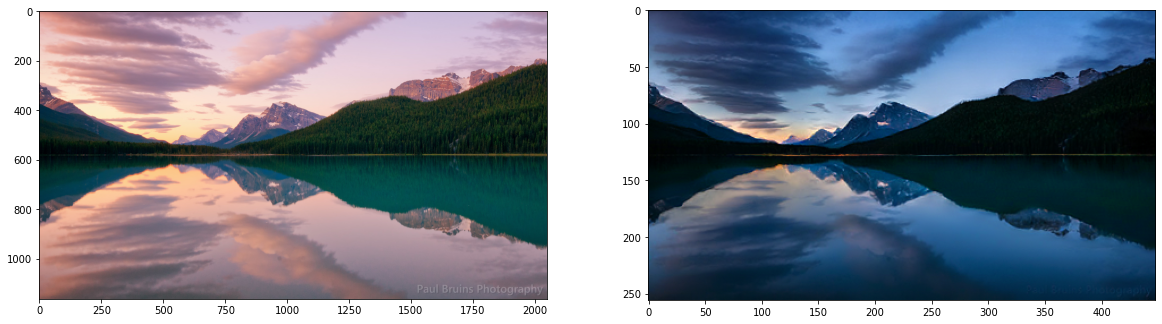

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(output_img)

# Load Image Enhance Network

In [8]:
enhancer_weights = 'trained_models/enhancer/enhancer.pth'
enhancer = RRDBNet(in_nc=48, out_nc=3, nf=64, nb=5, gc=32).to(device)
enhancer.load_state_dict(torch.load(enhancer_weights))

crop_transform = GridCrop(4, 1, hires_size=256 * 4)
crops = [img for img in crop_transform(img)]

print(len(crops))

16


# Inference
- 왜 16개로 crop해놓고 0번 결과만 쓰는걸까?

In [14]:
with torch.no_grad():
    crops = [i for i in crop_transform(img)]
    content_decomposition = style_transformer.get_content(crops)[0]

    decoder_input = {
        'content': content_decomposition['content'],
        'intermediate_outputs': content_decomposition['intermediate_outputs'],
        'style': style_to_transfer.repeat(16, 1, 1, 1)
    }

    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

    padded_stack = enhancement_preprocessing(transferred, normalize=False)
    out = enhancer(padded_stack)

enhanced_output_img = (out.cpu()[0].clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.

(1024, 1792, 3)


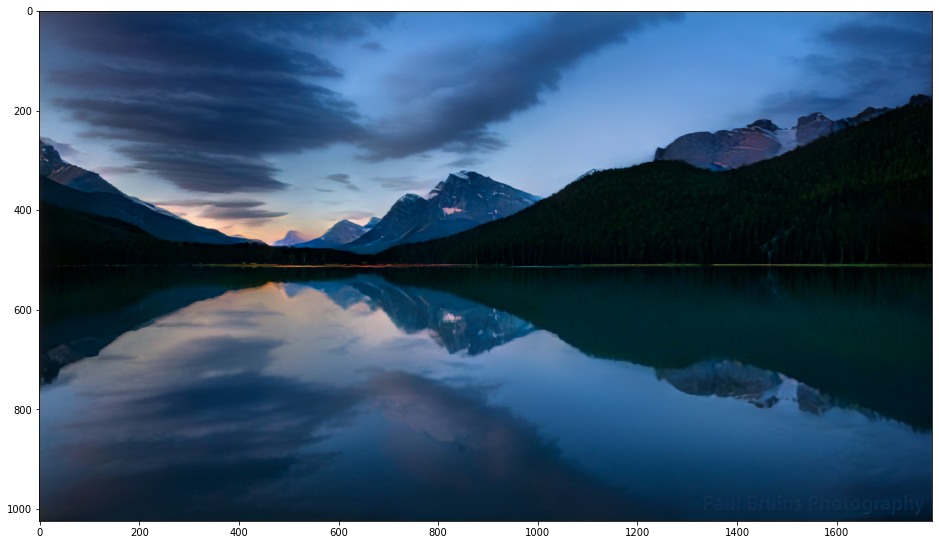

In [16]:
print(enhanced_output_img.shape)
plt.figure(figsize=(16, 10))
plt.imshow(enhanced_output_img)

# Result Comparison

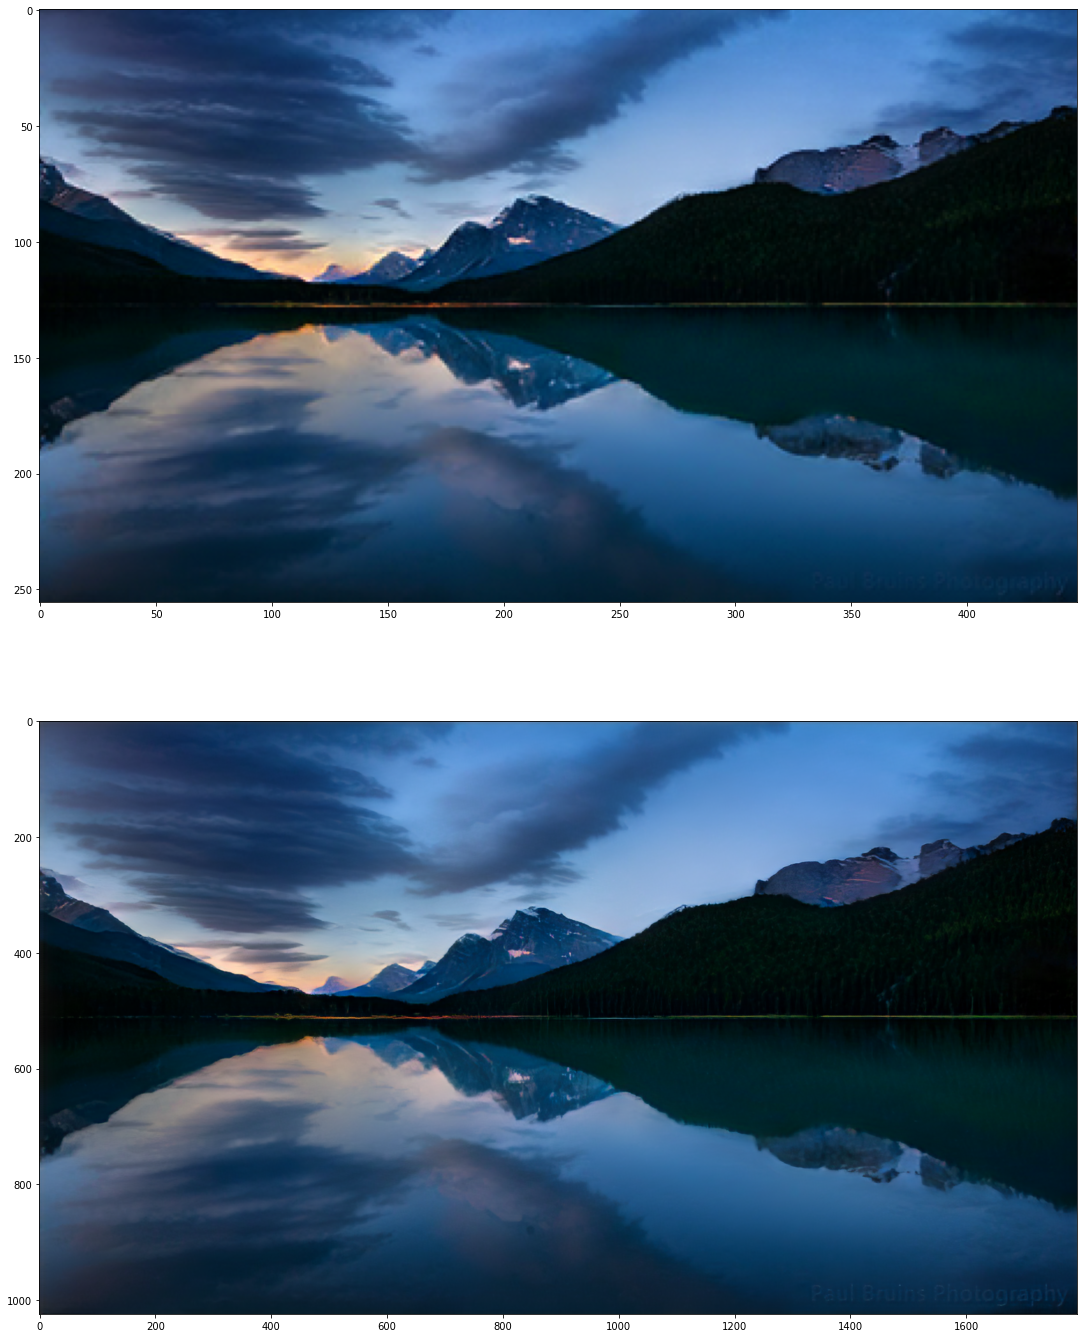

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(20, 24))
axes[0].imshow(output_img)
axes[1].imshow(enhanced_output_img)

# Functionalize

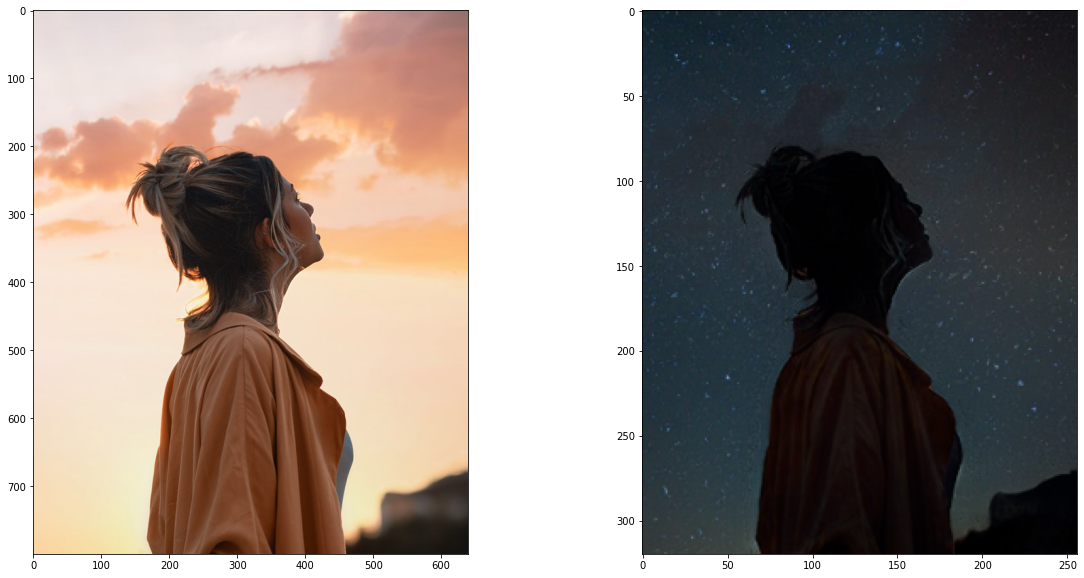

In [34]:
def transfer(img, style):
    style_to_transfer = styles[style]
    style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)

    with torch.no_grad():
        content_decomposition = style_transformer.get_content(img)[0]

        decoder_input = {
            'content': content_decomposition['content'],
            'intermediate_outputs': content_decomposition['intermediate_outputs'],
            'style': style_to_transfer
        }

        transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

    return (transferred[0].cpu().clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.
    
test_img = Image.open('images/test/01.jpg')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='night'))

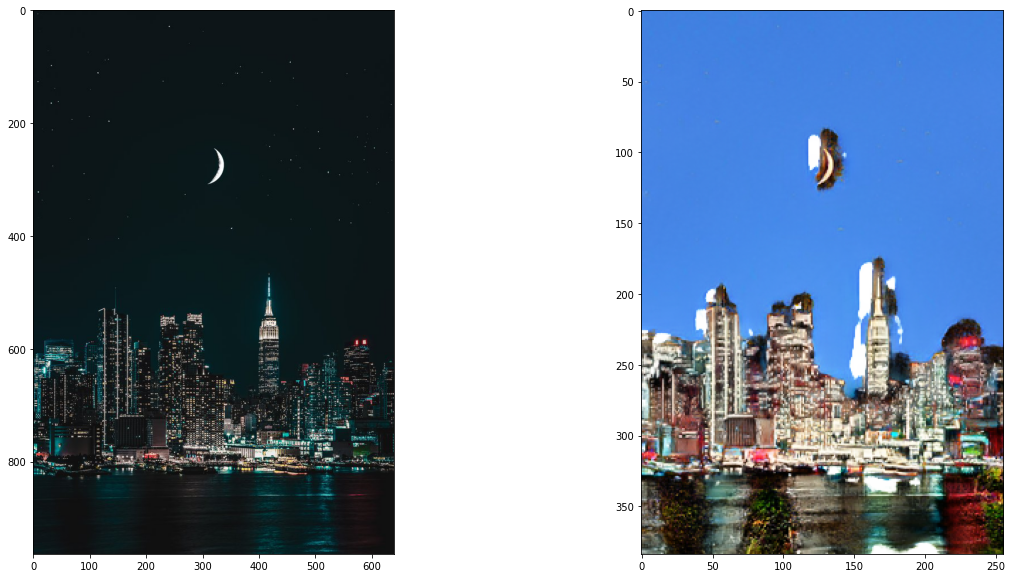

In [36]:
test_img = Image.open('images/test/02.jpg')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='day2'))

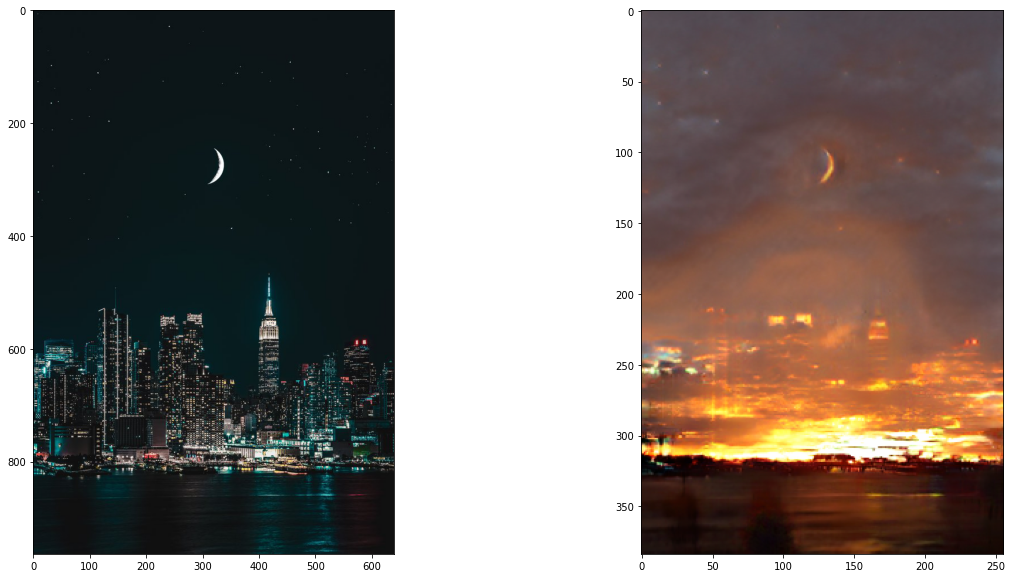

In [37]:
test_img = Image.open('images/test/02.jpg')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='sunset_hard_harder'))

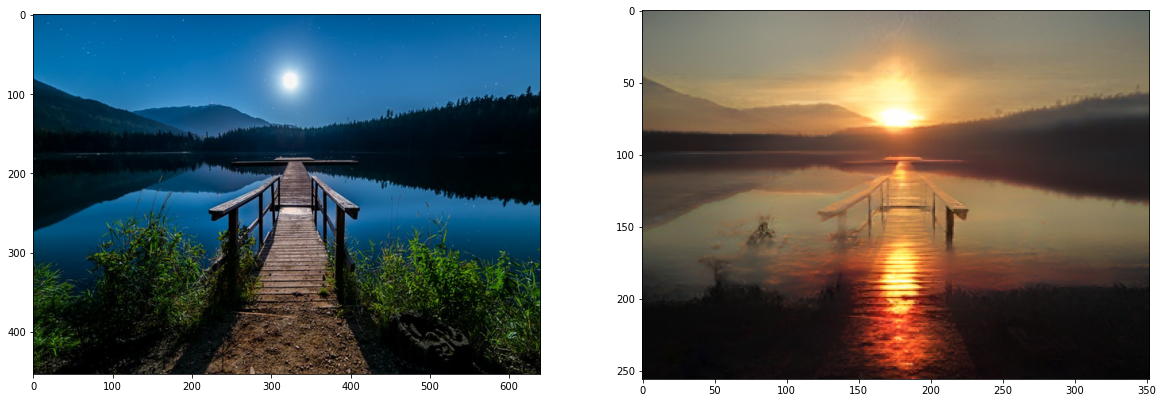

In [38]:
test_img = Image.open('images/test/03.jpg')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='sunset_hard_harder'))

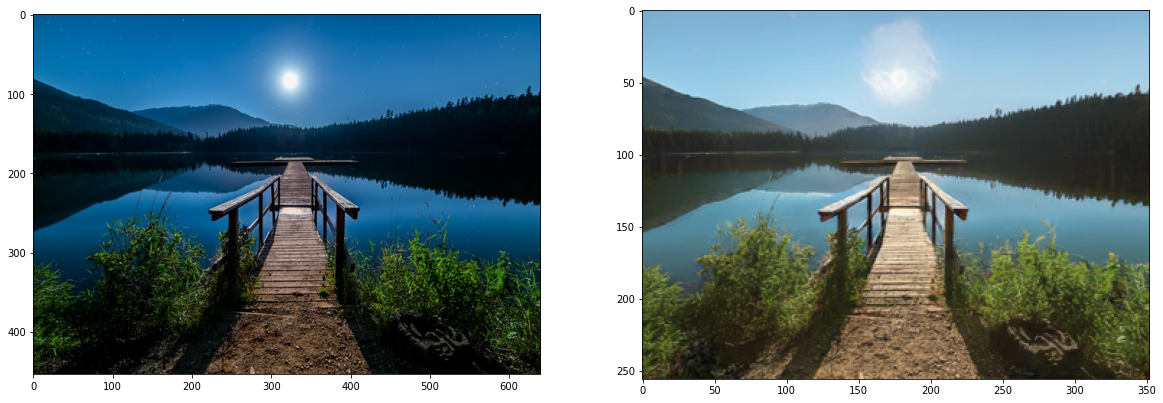

In [39]:
test_img = Image.open('images/test/03.jpg')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='semihard_day'))

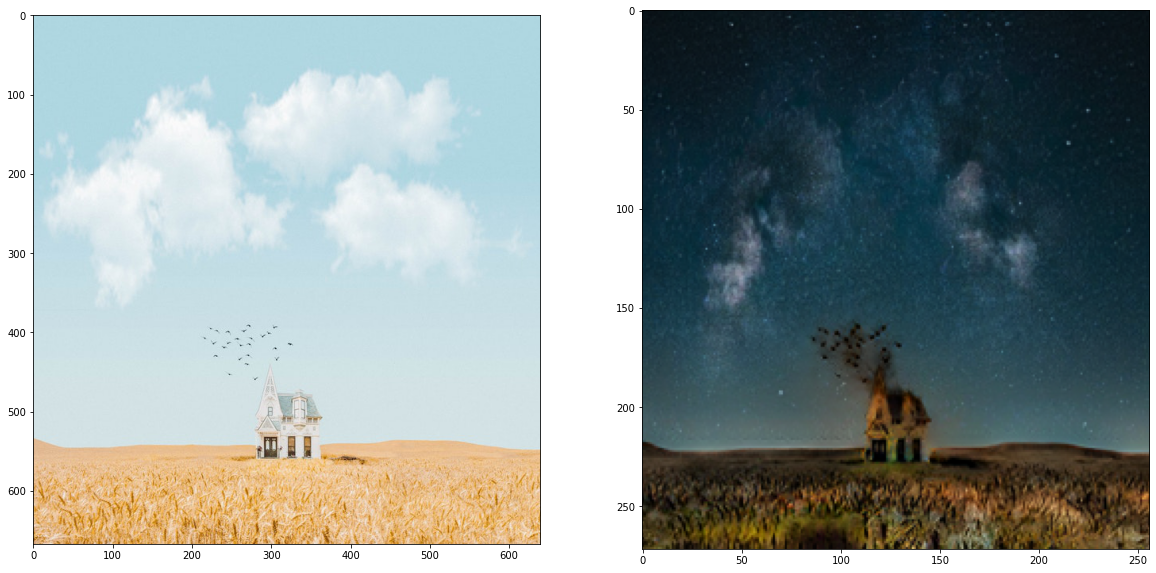

In [45]:
test_img = Image.open('images/test/04.jpg')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='darknight'))